## Analysis of feature selection for purity prediction; single-cancer holdouts

This script is very similar to `02_cancer_type_classification/plot_univariate_fs_results.ipynb`, for analyzing the results of purity prediction on held-out cancer types. We analyze the same 3 types of data splitting experiments here:

* "Train single cancer": train and test on the same individual cancer type
* "Train pan-cancer": train on the test cancer type + all other valid TCGA cancer types
* "Train all other cancers": train on all other valid TCGA cancer types (without the test cancer type in the training set)

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pancancer_evaluation.config as cfg
import pancancer_evaluation.utilities.analysis_utilities as au

%load_ext autoreload
%autoreload 2

In [2]:
# analysis of results generated by script:
# 07_purity_prediction/run_purity_prediction.py
# (with varying feature_selection parameters)

single_cancer_dir = os.path.join('results', 'purity_binary_median', 'single_cancer')
pancancer_dir = os.path.join('results', 'purity_binary_median', 'pancancer')
pancancer_only_dir = os.path.join('results', 'purity_binary_median', 'all_other_cancers')

large_n_dims = 1000
small_n_dims = 250

# metric to plot results for
metric = 'aupr'
delta_metric = 'delta_{}'.format(metric)

# location to save plots to
output_plots = True
if metric == 'auroc':
    output_plots_dir = cfg.purity_fs_plots_dir / 'auroc'
else:
    output_plots_dir = cfg.purity_fs_plots_dir

### Load results

We load the results of the single cancer, pan-cancer, and "pan-cancer only" (aka "all other cancers") experiments here.

In [3]:
single_cancer_df = au.load_purity_results_fs(
    single_cancer_dir, cfg.fs_methods, classify=True, cancer_type_from_fname=True
)
single_cancer_df['train_set'] = 'single_cancer'

single_cancer_df.loc[
    (single_cancer_df.fs_method == 'mad') & (single_cancer_df.n_dims == small_n_dims),
    'fs_method'
] = 'mad_{}'.format(small_n_dims)
single_cancer_df.loc[
    (single_cancer_df.fs_method == 'mad') & (single_cancer_df.n_dims == large_n_dims),
    'fs_method'
] = 'mad_{}'.format(large_n_dims)

single_cancer_df.drop(columns='gene', inplace=True)

print(np.unique(single_cancer_df.seed))
print(single_cancer_df.shape)
single_cancer_df.head()

[ 1 42]
(7920, 10)


,auroc,aupr,holdout_cancer_type,signal,seed,data_type,fold,fs_method,n_dims,train_set
0,0.93878,0.93248,LUAD,signal,1,train,0,median_f_test,250,single_cancer
1,0.86742,0.91092,LUAD,signal,1,test,0,median_f_test,250,single_cancer
2,0.87943,0.86389,LUAD,signal,1,cv,0,median_f_test,250,single_cancer
3,0.89421,0.88924,LUAD,signal,1,train,1,median_f_test,250,single_cancer
4,0.85668,0.83584,LUAD,signal,1,test,1,median_f_test,250,single_cancer


In [4]:
pancancer_df = au.load_purity_results_fs(
    pancancer_dir, cfg.fs_methods, classify=True, cancer_type_from_fname=True
)
pancancer_df['train_set'] = 'pancancer'

pancancer_df.loc[
    (pancancer_df.fs_method == 'mad') & (pancancer_df.n_dims == small_n_dims),
    'fs_method'
] = 'mad_{}'.format(small_n_dims)
pancancer_df.loc[
    (pancancer_df.fs_method == 'mad') & (pancancer_df.n_dims == large_n_dims),
    'fs_method'
] = 'mad_{}'.format(large_n_dims)

pancancer_df.drop(columns='gene', inplace=True)

print(np.unique(pancancer_df.seed))
print(pancancer_df.shape)
pancancer_df.head()

[ 1 42]
(7920, 10)


,auroc,aupr,holdout_cancer_type,signal,seed,data_type,fold,fs_method,n_dims,train_set
0,0.81420,0.80014,LUAD,signal,1,train,0,median_f_test,250,pancancer
1,0.83736,0.87788,LUAD,signal,1,test,0,median_f_test,250,pancancer
2,0.78334,0.76133,LUAD,signal,1,cv,0,median_f_test,250,pancancer
3,0.81430,0.80074,LUAD,signal,1,train,1,median_f_test,250,pancancer
4,0.82406,0.79092,LUAD,signal,1,test,1,median_f_test,250,pancancer


In [5]:
pancancer_only_df = au.load_purity_results_fs(
    pancancer_only_dir, cfg.fs_methods, classify=True, cancer_type_from_fname=True
)
pancancer_only_df['train_set'] = 'pancancer_only'

pancancer_only_df.loc[
    (pancancer_only_df.fs_method == 'mad') & (pancancer_only_df.n_dims == small_n_dims),
    'fs_method'
] = 'mad_{}'.format(small_n_dims)
pancancer_only_df.loc[
    (pancancer_only_df.fs_method == 'mad') & (pancancer_only_df.n_dims == large_n_dims),
    'fs_method'
] = 'mad_{}'.format(large_n_dims)

pancancer_only_df.drop(columns='gene', inplace=True)

print(np.unique(pancancer_only_df.seed))
print(pancancer_only_df.shape)
pancancer_only_df.head()

[ 1 42]
(7920, 10)


,auroc,aupr,holdout_cancer_type,signal,seed,data_type,fold,fs_method,n_dims,train_set
0,0.81420,0.80161,LUAD,signal,1,train,0,median_f_test,250,pancancer_only
1,0.82340,0.86305,LUAD,signal,1,test,0,median_f_test,250,pancancer_only
2,0.78260,0.75968,LUAD,signal,1,cv,0,median_f_test,250,pancancer_only
3,0.81420,0.80161,LUAD,signal,1,train,1,median_f_test,250,pancancer_only
4,0.81925,0.79802,LUAD,signal,1,test,1,median_f_test,250,pancancer_only


In [6]:
# get difference between true and shuffled models, split by
# feature selection method and holdout cancer type
def compare_from_experiment(experiment_df):
    compare_df = []
    for fs_method in experiment_df.fs_method.unique():
        compare_df.append(
            au.compare_control_ind(
                experiment_df[experiment_df.fs_method == fs_method], 
                identifier='holdout_cancer_type', metric=metric, verbose=True)
              .assign(fs_method=fs_method)
        )
    return pd.concat(compare_df)
    
single_cancer_compare_df = compare_from_experiment(single_cancer_df)
pancancer_compare_df = compare_from_experiment(pancancer_df)
pancancer_only_compare_df = compare_from_experiment(pancancer_only_df)

print(single_cancer_compare_df.shape,
      pancancer_compare_df.shape,
      pancancer_only_compare_df.shape)

(1320, 5) (1320, 5) (1320, 5)


In [7]:
single_cancer_compare_df.head()

,identifier,seed,fold,delta_aupr,fs_method
0,ACC,1,0,0.31718,median_f_test
1,ACC,1,1,0.11048,median_f_test
2,ACC,1,2,0.13334,median_f_test
3,ACC,1,3,0.40464,median_f_test
4,ACC,42,0,0.34345,median_f_test


### Plot average performance across cancer types

In [8]:
print(single_cancer_compare_df.identifier.unique())

['ACC' 'BLCA' 'BRCA' 'CESC' 'CHOL' 'COAD' 'DLBC' 'ESCA' 'GBM' 'HNSC'
 'KICH' 'KIRC' 'KIRP' 'LAML' 'LGG' 'LIHC' 'LUAD' 'LUSC' 'MESO' 'OV' 'PAAD'
 'PCPG' 'PRAD' 'READ' 'SARC' 'SKCM' 'STAD' 'TGCT' 'THCA' 'THYM' 'UCEC'
 'UCS' 'UVM']


In [9]:
print(single_cancer_compare_df.fs_method.unique())

['median_f_test' 'random' 'mad_1000' 'pancan_f_test' 'mad_250']


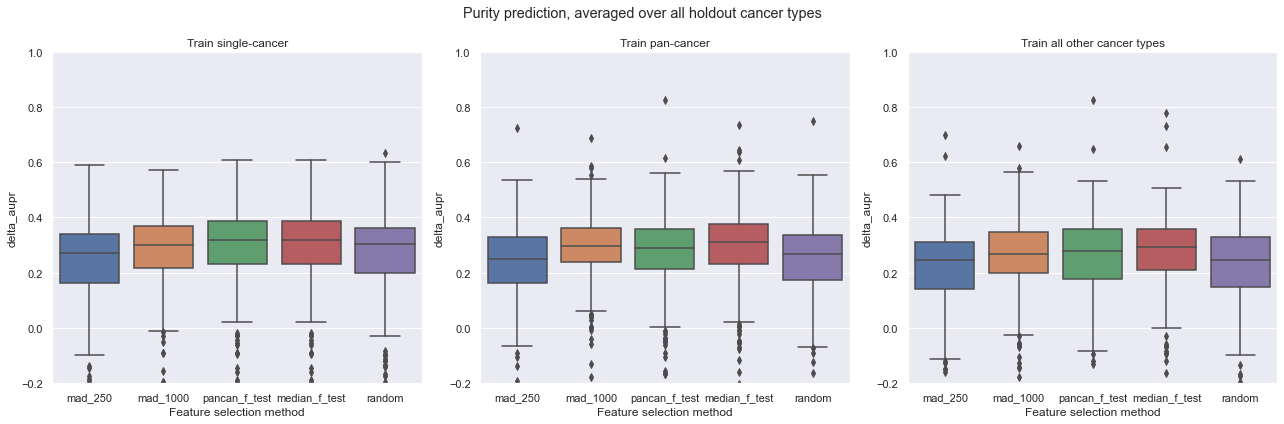

In [10]:
sns.set({'figure.figsize': (18, 6)})
sns.set_context('notebook')

fig, axarr = plt.subplots(1, 3)

dfs_to_plot = [
    single_cancer_compare_df,
    pancancer_compare_df,
    pancancer_only_compare_df
]

names_to_plot = [
    'Train single-cancer',
    'Train pan-cancer',
    'Train all other cancer types'
]

fs_method_order = [
    'mad_250',
    'mad_1000',
    'pancan_f_test',
    'median_f_test',
    'random'
]


for ix, compare_df in enumerate(dfs_to_plot):
    ax = axarr[ix]
    # averaged over cancer types
    sns.boxplot(data=compare_df, x='fs_method', y=delta_metric,
                order=fs_method_order, ax=ax)
    ax.set_title(names_to_plot[ix])
    ax.set_xlabel('Feature selection method')
    ax.set_ylim(-0.2, 1)
    
plt.suptitle('Purity prediction, averaged over all holdout cancer types')
plt.tight_layout()

if output_plots:
    output_plots_dir.mkdir(exist_ok=True)
    plt.savefig(output_plots_dir / 'purity_all_summary.png',
                dpi=200, bbox_inches='tight')

In [11]:
# these are "non-carcinoma" cancer types in TCGA
# we anticipate that these will be the hardest to transfer models to (since
# most of TCGA, and thus most of our training set, is generally carcinomas),
# so it's valuable to look at results filtered only to these
non_carcinomas = [
    'DLBC',
    'GBM',
    'LAML',
    'LGG',
    'PCPG',
    'SARC',
    'SKCM',
    'TGCT',
    'UVM'
]

['DLBC' 'GBM' 'LAML' 'LGG' 'PCPG' 'SARC' 'SKCM' 'TGCT' 'UVM']


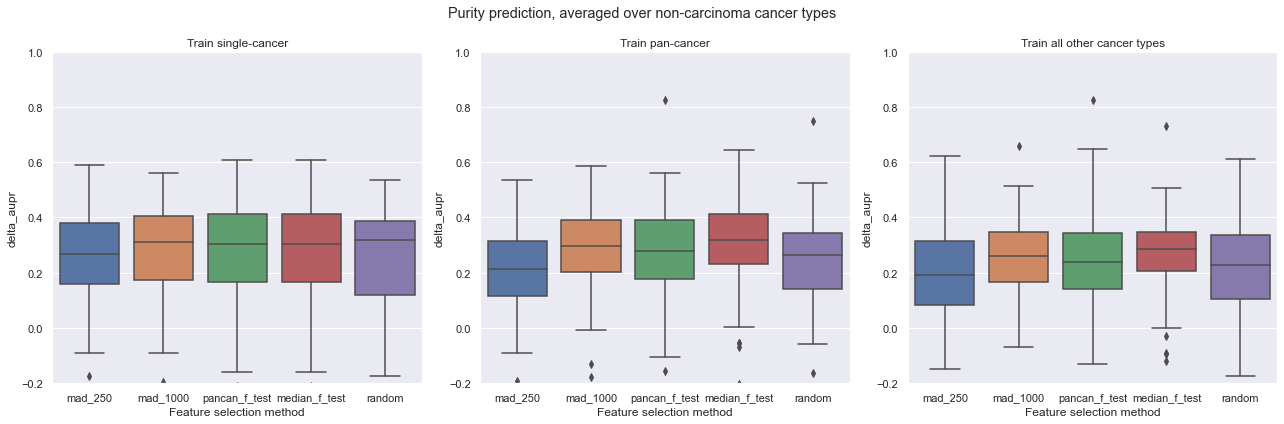

In [12]:
sns.set({'figure.figsize': (18, 6)})
sns.set_context('notebook')

fig, axarr = plt.subplots(1, 3)

dfs_to_plot = [
    single_cancer_compare_df,
    pancancer_compare_df,
    pancancer_only_compare_df
]

names_to_plot = [
    'Train single-cancer',
    'Train pan-cancer',
    'Train all other cancer types'
]


for ix, compare_df in enumerate(dfs_to_plot):
    ax = axarr[ix]
    # averaged over non-carcinoma cancer types
    plot_df = compare_df[(compare_df.identifier.isin(non_carcinomas))]
    if ix == 0:
        # look at which cancer types are actually present in dataset
        # for purity prediction it should be all of them
        print(plot_df.identifier.unique(), file=sys.stderr)
    sns.boxplot(data=plot_df, x='fs_method', y=delta_metric,
                order=fs_method_order, ax=ax)
    ax.set_title(names_to_plot[ix])
    ax.set_xlabel('Feature selection method')
    ax.set_ylim(-0.2, 1)
    
plt.suptitle('Purity prediction, averaged over non-carcinoma cancer types')
plt.tight_layout()

if output_plots:
    plt.savefig(output_plots_dir / 'purity_non_carcinoma_summary.png',
                dpi=200, bbox_inches='tight')

### Plot performance broken down by cancer type

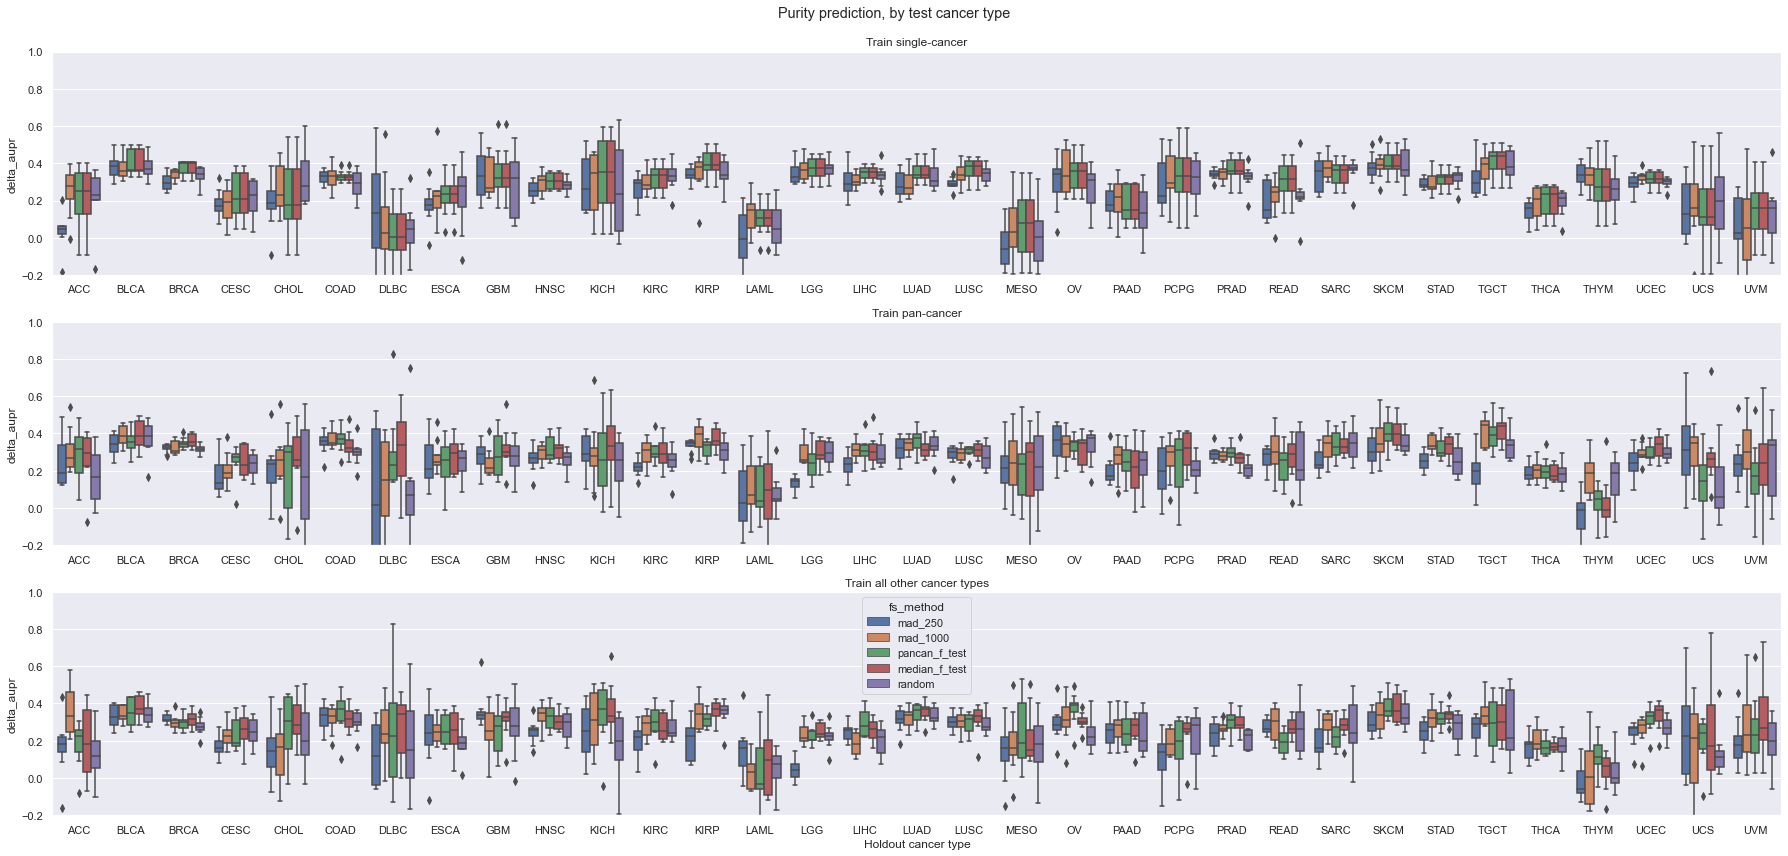

In [13]:
sns.set({'figure.figsize': (25, 12)})
sns.set_context('notebook')

fig, axarr = plt.subplots(3, 1)

dfs_to_plot = [
    single_cancer_compare_df,
    pancancer_compare_df,
    pancancer_only_compare_df
]

names_to_plot = [
    'Train single-cancer',
    'Train pan-cancer',
    'Train all other cancer types'
]

# split individual cancer types
for ix, to_plot_df in enumerate(dfs_to_plot):
    ax = axarr[ix]
    plot_df = (
        to_plot_df.sort_values(by='identifier')
    )
    sns.boxplot(data=plot_df, x='identifier', 
                y=delta_metric, hue='fs_method', 
                hue_order=fs_method_order, ax=ax)
    ax.set_title(names_to_plot[ix])
    if ix == len(dfs_to_plot) - 1:
        ax.set_xlabel('Holdout cancer type')
    else:
        ax.set_xlabel('')
        ax.get_legend().remove()
    ax.set_ylim(-0.2, 1)
    
plt.suptitle('Purity prediction, by test cancer type', y=0.99)
plt.tight_layout()

if output_plots:
    plt.savefig(output_plots_dir / 'purity_all_by_cancer_type.png',
                dpi=200, bbox_inches='tight')

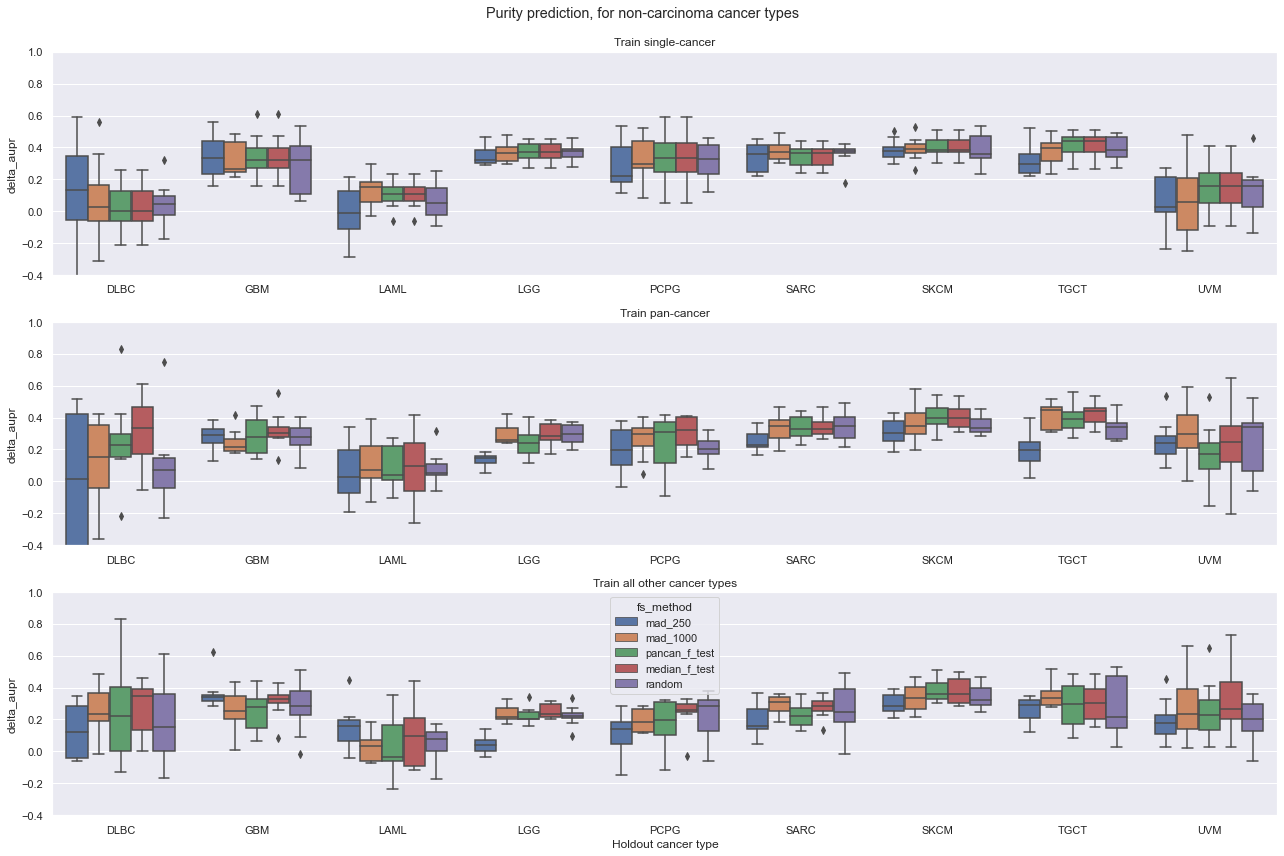

In [14]:
sns.set({'figure.figsize': (18, 12)})
sns.set_context('notebook')

fig, axarr = plt.subplots(3, 1)

dfs_to_plot = [
    single_cancer_compare_df,
    pancancer_compare_df,
    pancancer_only_compare_df
]

names_to_plot = [
    'Train single-cancer',
    'Train pan-cancer',
    'Train all other cancer types'
]

# split individual cancer types
for ix, to_plot_df in enumerate(dfs_to_plot):
    ax = axarr[ix]
    plot_df = (
        to_plot_df[to_plot_df.identifier.isin(non_carcinomas)]
          .sort_values(by='identifier')
    )
    sns.boxplot(data=plot_df, x='identifier', 
                y=delta_metric, hue='fs_method', 
                hue_order=fs_method_order, ax=ax)
    ax.set_title(names_to_plot[ix])
    if ix == len(dfs_to_plot) - 1:
        ax.set_xlabel('Holdout cancer type')
    else:
        ax.set_xlabel('')
        ax.get_legend().remove()
    ax.set_ylim(-0.4, 1)
    
plt.suptitle('Purity prediction, for non-carcinoma cancer types', y=0.99)
plt.tight_layout()

if output_plots:
    plt.savefig(output_plots_dir / 'purity_non_carcinoma_by_cancer_type.png',
                dpi=200, bbox_inches='tight')

### Plot performance broken down by cancer type and test set

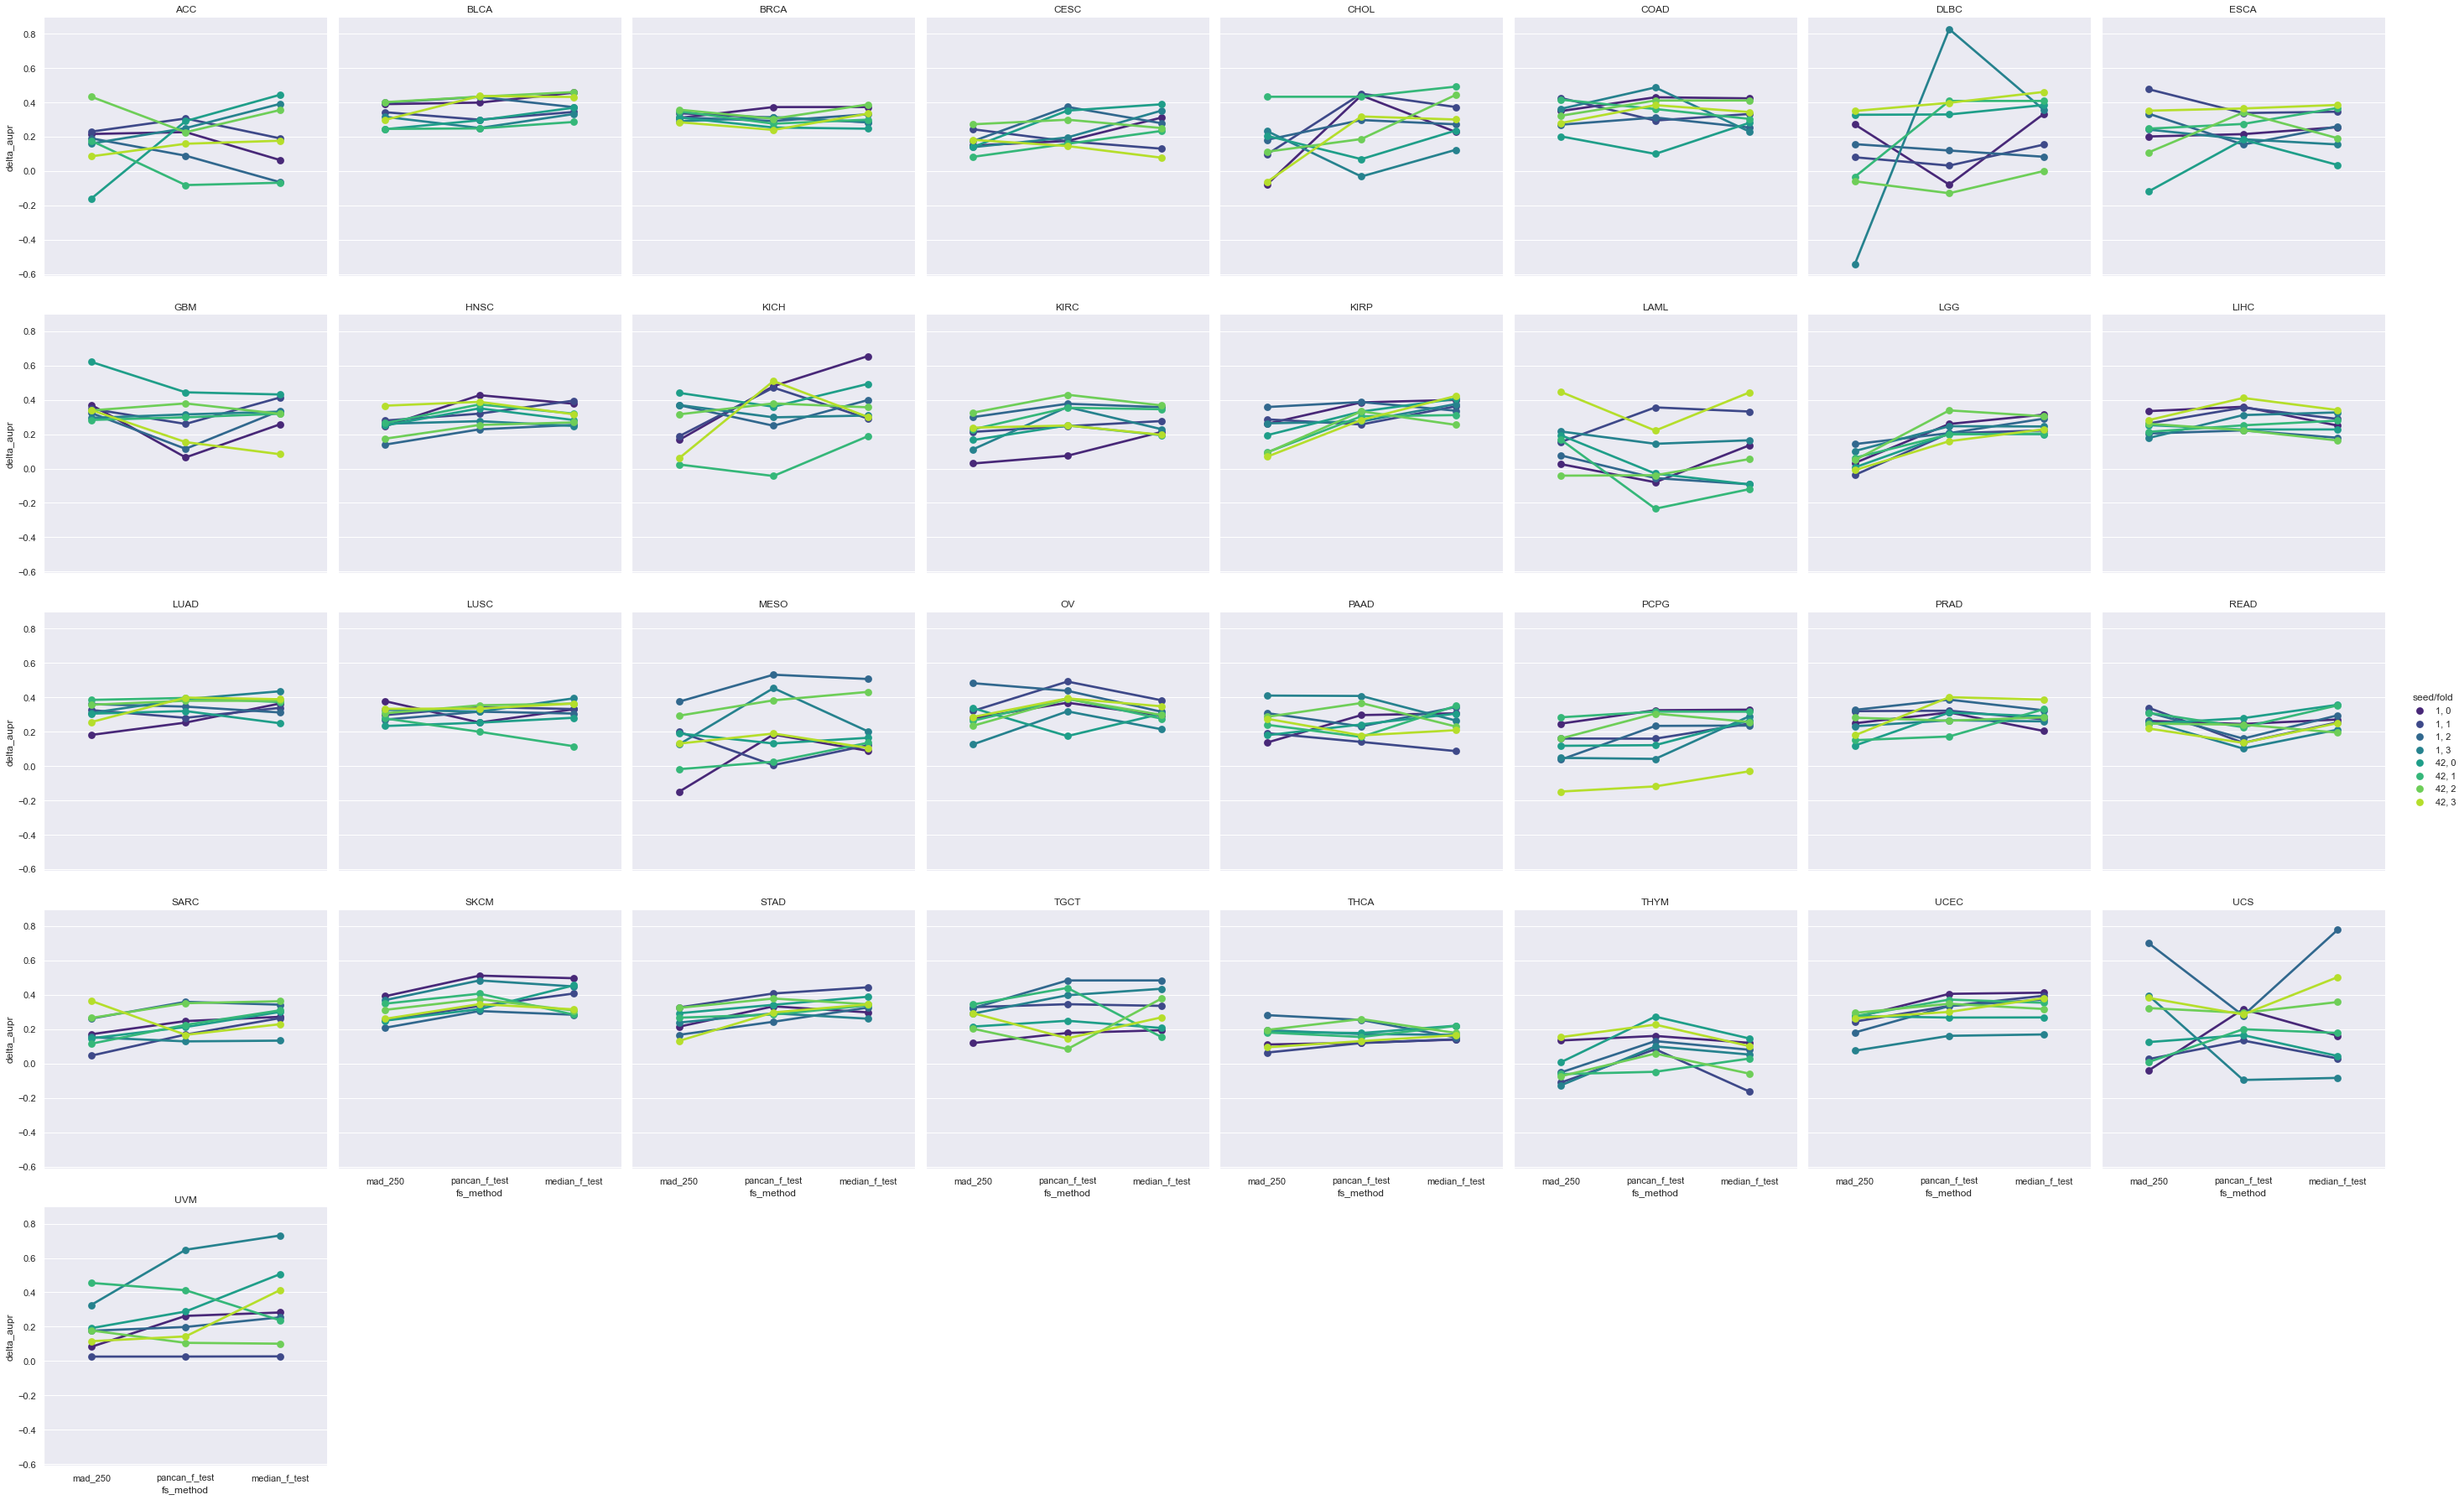

In [15]:
sns.set({'figure.figsize': (15, 6)})
sns.set_context('notebook')

plot_fs_methods = [
    'mad_250',
    'pancan_f_test',
    'median_f_test'
]

plot_df = (
    pancancer_only_compare_df[
        (pancancer_only_compare_df.fs_method.isin(plot_fs_methods))
    ].sort_values(by='identifier')
).sort_values(by=['seed', 'fold'])
plot_df['seed/fold'] = plot_df.seed.astype(str) + ', ' + plot_df.fold.astype(str)

g = sns.catplot(
    data=plot_df, x='fs_method', y=delta_metric, col='identifier',
    hue='seed/fold', kind='point', col_wrap=8, order=plot_fs_methods,
    palette='viridis'
)
g.set_titles(col_template='{col_name}')

if output_plots:
    plt.savefig(output_plots_dir / 'purity_by_cancer_type_lines.png',
                dpi=200, bbox_inches='tight')

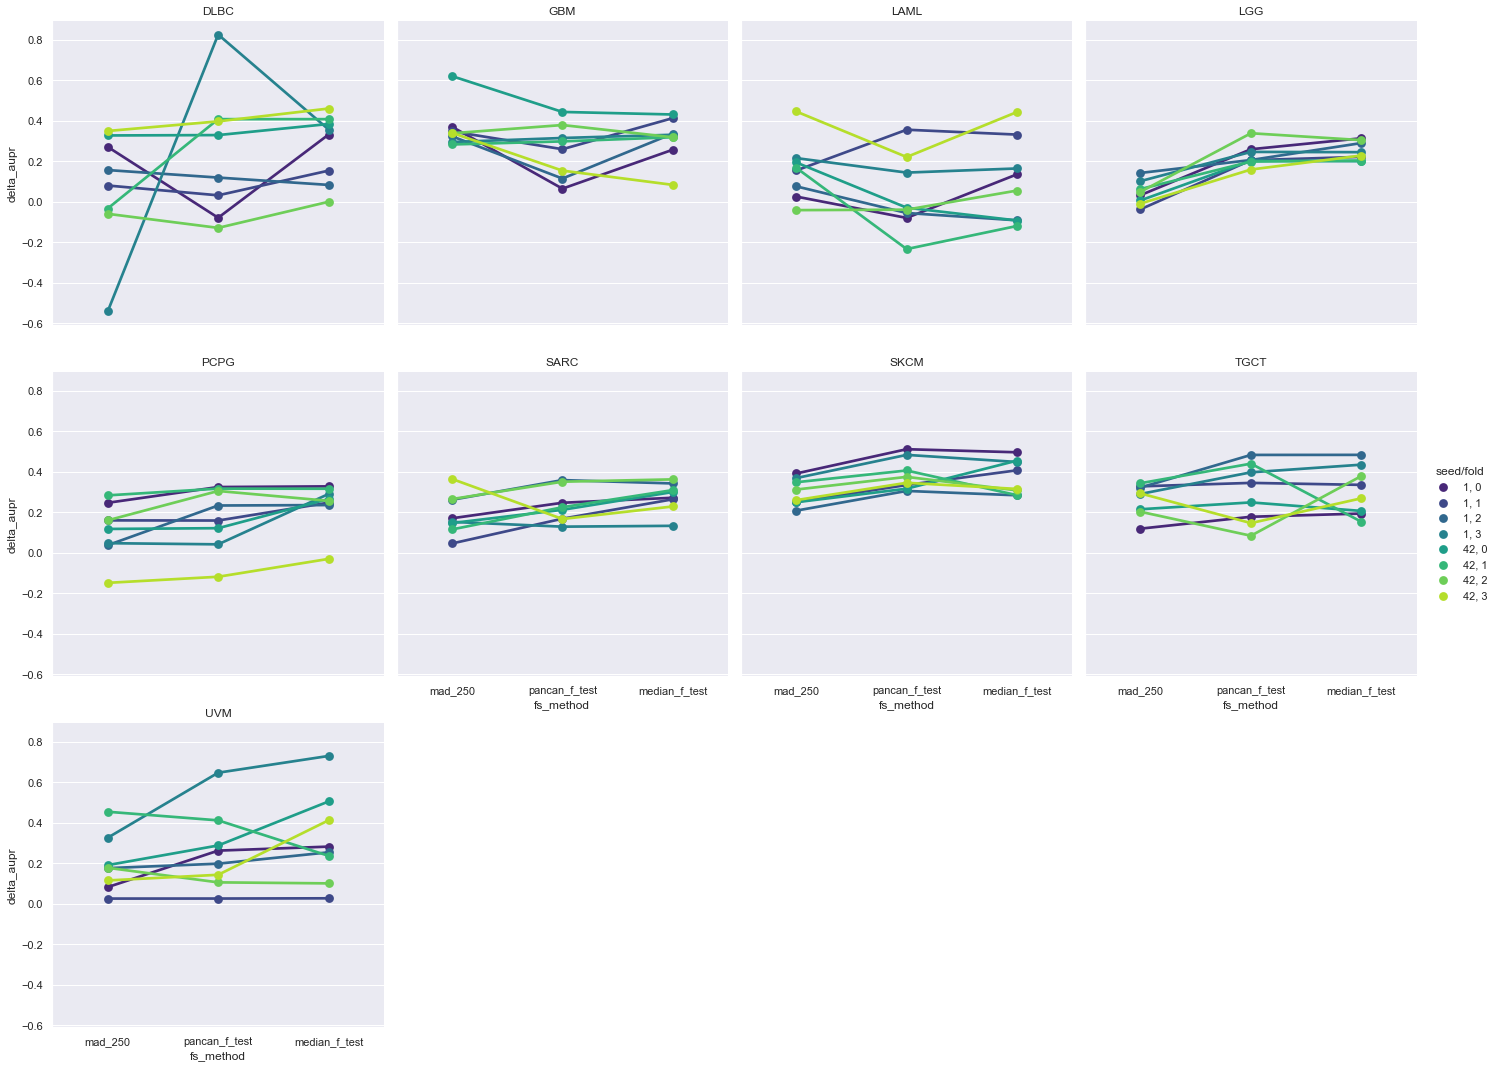

In [16]:
sns.set({'figure.figsize': (15, 6)})
sns.set_context('notebook')

plot_fs_methods = [
    'mad_250',
    'pancan_f_test',
    'median_f_test'
]

plot_df = (
    pancancer_only_compare_df[
        (pancancer_only_compare_df.identifier.isin(non_carcinomas)) &
        (pancancer_only_compare_df.fs_method.isin(plot_fs_methods))
    ].sort_values(by='identifier')
).sort_values(by=['seed', 'fold'])
plot_df['seed/fold'] = plot_df.seed.astype(str) + ', ' + plot_df.fold.astype(str)

g = sns.catplot(
    data=plot_df, x='fs_method', y=delta_metric, col='identifier',
    hue='seed/fold', kind='point', col_wrap=4, order=plot_fs_methods,
    palette='viridis'
)
g.set_titles(col_template='{col_name}')

if output_plots:
    plt.savefig(output_plots_dir / 'purity_non_carcinoma_by_cancer_type_lines.png',
                dpi=200, bbox_inches='tight')

In general for purity prediction, we see that the univariate f-test methods `pancan_f_test` and `median_f_test` do perform slightly better than the other methods, particularly for the non-carcinoma data types, but the effect isn't nearly as obvious as it is for some of the mutation prediction examples, and variance is much higher overall.